In [1]:
%load_ext autoreload
%autoreload 2
import tests
import utils.utils as utils
import matplotlib.pyplot as plt
import torch
import torch.utils.data as tdata
import numpy as np
import pandas as pd
import sys
from dots_boxes.dots_boxes_game import BoxesState
from test.nn_unittests import load_boards_samples
import configuration
from nn import NeuralNetWrapper

In [2]:
df = load_boards_samples()
df

,moves,next_moves,z,game
id,,,,
-1,"[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 1...",[25],1,------------------------------\nJust played = ...
0,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24, 0]",[4],1,------------------------------\nJust played = ...
1,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24,...",[8],1,------------------------------\nJust played = ...
2,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24,...",[25],1,------------------------------\nJust played = ...
3,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24,...",[26],1,------------------------------\nJust played = ...
4,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24,...",[27],1,------------------------------\nJust played = ...
5,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24]","[2, 19]",1,------------------------------\nJust played = ...
6,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24, 2]",[19],-1,------------------------------\nJust played = ...
7,"[6, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24,...","[1, 5, 22, 23]",-1,------------------------------\nJust played = ...


In [ ]:
params = configuration.params
params.rewrite_str("_exp_", "resnet20_1229")
model = params.nn.model_class(params)
wrapper = NeuralNetWrapper(model, params)
model.load_parameters(40)

for i, sample in df.iterrows():
    print(i)
    print(sample.game)
    print("Next moves:", sample.next_moves)
    print("Z:", sample.z)
    p, v = wrapper.predict_sync(np.expand_dims(sample.game.get_features(), 0))
    for i, p in enumerate(p.round(2)[0]):
        if p>0.0:
            print(f"{i}->{p:.2f}", end="; ")
    print("")
    print("v:", v[0])

In [10]:
with pd.HDFStore("data/resnet20_1229_test_200/sp_data.hdf", mode="r") as hdf:
    data = hdf.select("data", where="generation>=0").sort_index(ascending=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f796b2f95f8>,
      dtype=object)

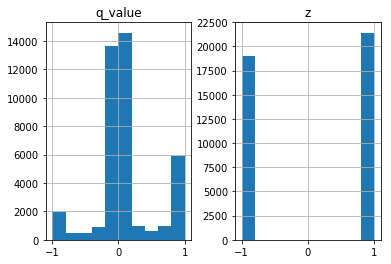

In [3]:
data[["z", "q_value"]].hist()

In [8]:
BoxesState.init_static_fields(((3,3),))
g = BoxesState()
index = data.index

game = data.loc[7,132,1:]


for i, row in game.iterrows(): #move.values[1:]:
    g.play_(int(row.move))
    print()
    print("move:", row.move)
    print("z:", row.z)
    print("q_value:", row.q_value)
    print("player:",row.player)
    print(g)
    pi = row[list(f"pi_{i}" for i in range(32))].values
    print("; ".join(f"{i}->{round(pi[i], 3)}" for i in pi.argsort()[31:25:-1]))
    


move: 22.0
z: 1.0
q_value: -0.0017954959766939282
player: 0.0
------------------------------
Just played = 1
To play = 0
Boxes to close = [4.5, 4.5]
Result = None
+   +   +   +
                
+   +   +   +
        |       
+   +   +   +
                
+   +   +   +

0->0.239; 19->0.175; 18->0.146; 27->0.14; 17->0.12; 8->0.013

move: 27.0
z: -1.0
q_value: 0.0031175666954368353
player: 1.0
------------------------------
Just played = 0
To play = 1
Boxes to close = [4.5, 4.5]
Result = None
+   +   +   +
                
+   +   +   +
        |       
+   +   +   +
            |   
+   +   +   +

14->0.122; 26->0.118; 6->0.109; 13->0.109; 2->0.108; 5->0.102

move: 0.0
z: 1.0
q_value: 0.022081531584262848
player: 0.0
------------------------------
Just played = 1
To play = 0
Boxes to close = [4.5, 4.5]
Result = None
+---+   +   +
                
+   +   +   +
        |       
+   +   +   +
            |   
+   +   +   +

4->0.084; 9->0.084; 19->0.083; 5->0.083; 8->0.081; 20->0.078

mo

In [12]:
sampled_data = data.loc[tuple(range(0, 9, 1)), :, :].reset_index()#.sample(100000)

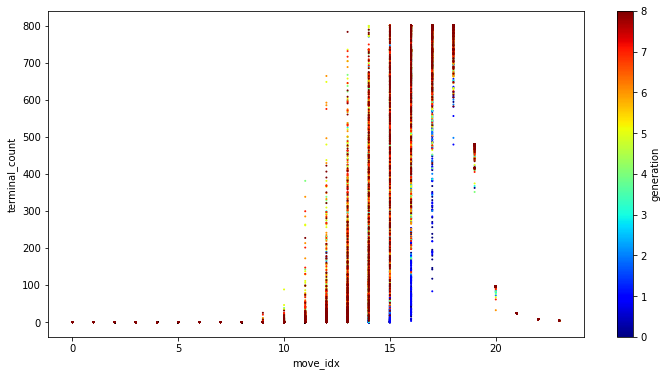

In [13]:
axs = sampled_data.plot.scatter("move_idx", "terminal_count", s=1, c="generation", colormap="jet", figsize=(12,6), sharex=False)

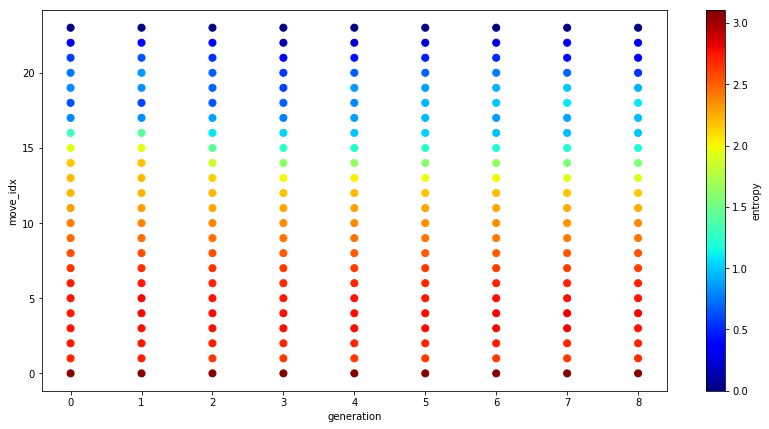

In [14]:
df_entropy = sampled_data[["generation", "move_idx", "move", "player"]]
pi = sampled_data[[f"pi_{i:d}" for i in range(32)]].values
pi[pi==0] = 1
entropy = -(pi*np.log(pi)).sum(1)
df_entropy = df_entropy.assign(entropy = entropy)
df_entropy = df_entropy.groupby(by=["generation", "move_idx"]).mean()[["entropy"]]
df_entropy.reset_index().plot.scatter("generation", "move_idx", s=50, c="entropy", colormap="jet", figsize=(14,7), sharex=False)

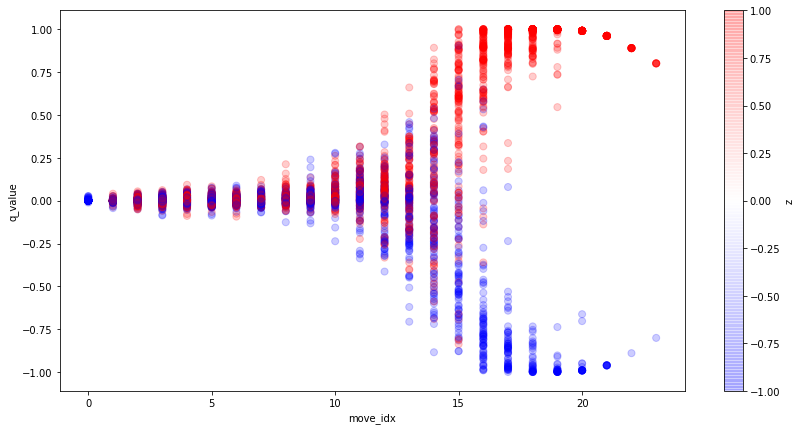

In [17]:
splitted = sampled_data.copy()
#splitted.loc[splitted.player==1, "generation"] += 0.1
axs = splitted[splitted.generation==3].plot.scatter("move_idx", "q_value", s=50, alpha=0.2, c="z", colormap="bwr", figsize=(14,7), sharex=False)

In [21]:
splitted[(splitted.generation==8)&(splitted.z==1)&(splitted.move_idx>5)&(splitted.q_value<0.1)].head(20)

,generation,game_idx,move_idx,move,player,x_0,x_1,x_2,x_3,x_4,...,pi_28,pi_29,pi_30,pi_31,z,max_deepness,tree_size,terminal_count,q_value,training
32171,8,0,6,9,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1,4,62,0,0.006396,-1
32173,8,0,8,19,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1,5,98,0,-0.000038,1
32175,8,0,10,26,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1,6,138,0,0.077067,1
32176,8,0,11,16,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1,6,120,0,0.099580,1
32193,8,1,6,22,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1,4,62,0,0.016956,1
32195,8,1,8,8,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1,5,73,0,0.012273,1
32197,8,1,10,12,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1,6,123,0,0.096180,1
32212,8,2,7,12,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,1,4,63,0,0.000809,1
32214,8,2,9,18,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,1,4,78,0,0.003784,1
32233,8,3,7,2,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,1,5,68,0,0.002728,1


In [1]:
#from dots_boxes.dots_boxes_nn import SimpleNN
from nn import NeuralNetWrapper, ResNetZero
import configuration
params = configuration.resnet20

generation = 0
show_values= False

where = "generation==0"
train_ds = tdata.DataLoader(utils.HDFStoreDataset("data/simple_2310/sp_data.hdf", "data", train=True, features_shape=params.game.clazz.FEATURES_SHAPE, where=where), batch_size=256)
val_ds = tdata.DataLoader(utils.HDFStoreDataset("data/simple_2310/sp_data.hdf", "data", train=False, features_shape=params.game.clazz.FEATURES_SHAPE, where=where), batch_size=256)
model = SimpleNN(params)
model.load_parameters(21)
model.cuda(1)
wrapper = NeuralNetWrapper(model, params)

def plot(ds):
    vs = []
    zs = []
    for batch in ds:
        zs.append(batch[2].detach().numpy())
        p, v = model(torch.tensor(batch[0]).cuda(1))
        vs.append(v.cpu().detach().numpy())

    vs = np.concatenate(vs)
    zs = np.concatenate(zs)
    if show_values:
        print(vs.sum(), zs.sum())
        print(np.concatenate((vs, zs), axis=1))
    v_m1 = np.zeros(len(vs))
    v_p1 = np.zeros(len(vs))
    for i, (v,z) in enumerate(zip(vs, zs)):
        if z<0:
            v_m1[i] = v
        else:
            v_p1[i] = v

    plt.figure()
    plt.hist([v_m1, v_p1], bins=1000, label=["-1", "+1"], log=False, cumulative=True, density=True, histtype="step")
    _ = plt.grid()


plot(train_ds)
plot(val_ds)

AttributeError: module 'configuration' has no attribute 're'

In [2]:
import pandas as pd
import numpy as np

In [2]:
hdf = pd.HDFStore("data/simple2710/sp_data.hdf", mode="r")
data = hdf.select("data", where=None).sort_index(ascending=True)
data.describe()

,move,player,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,pi_28,pi_29,pi_30,pi_31,z,max_deepness,tree_size,terminal_count,q_value,training
count,386961.000000,386961.000000,386961.000000,386961.000000,386961.000000,386961.0,386961.000000,386961.000000,386961.000000,386961.0,...,386961.0,386961.0,386961.0,386961.0,386961.000000,386961.000000,386961.000000,386961.000000,386961.000000,386961.000000
mean,13.572967,0.471029,0.436189,0.348118,0.431162,0.0,0.380072,0.365996,0.439814,0.0,...,0.0,0.0,0.0,0.0,0.102550,4.251790,668.945793,286.793026,0.051548,0.800001
std,8.602477,0.499161,0.495912,0.476374,0.495239,0.0,0.485405,0.481709,0.496365,0.0,...,0.0,0.0,0.0,0.0,0.994729,6.276769,846.085196,365.533480,0.586773,0.600000
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,-25.000000,0.000000,0.000000,-0.998752,-1.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,4.000000,83.000000,0.000000,-0.032147,1.000000
50%,14.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,5.000000,248.000000,0.000000,0.000000,1.000000
75%,21.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,7.000000,1007.000000,784.000000,0.078105,1.000000
max,27.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,15.000000,5785.000000,800.000000,0.998752,1.000000


In [15]:
data.loc[data.index.get_level_values('move_idx') > 18].head(20)

move  player  x_0  x_1  x_2  x_3  x_4  x_5  x_6  \
generation game_idx move_idx                                                    
0          0        19          18       1    1    1    1    0    1    1    1   
           1        19          12       1    1    1    0    0    1    1    1   
                    20          18       1    1    1    0    0    1    1    1   
                    21           2       1    1    1    1    0    1    1    1   
           2        19          10       0    1    1    0    0    1    1    1   
           3        19          10       0    1    1    1    0    1    1    1   
                    20           9       0    1    1    1    0    1    1    1   
           4        19          12       0    1    1    1    0    1    1    1   
           5        19          18       1    1    1    1    0    1    1    1   
           6        19          10       1    1    1    1    0    0    1    1   
                    20          14       1    1    1    1    0    0    1    1   
           7        19           4       1    1    1    0    0    1    1    1   
                    20           2       1    1    1    1    0    1    1    1   
           8        19           9       0    1    1    0    0    1    1    1   
                    20          16       0    1    1    0    0    1    1    1   
           9        19           4       1    1    1    1    0    1    1    1   
                    20          10       1    1    1    1    0    1    1    1   
                    21          21       1    1    1    1    0    1    1    1   
           10       19          23       0    1    0    0    0    1    1    1   
           11       19          16       0    1    0    0    0    0    1    1   

                              x_7    ...     pi_28  pi_29  pi_30  pi_31  z  \
generation game_idx move_idx         ...                                     
0          0        19          0    ...       0.0    0.0    0.0    0.0  1   
           1        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
                    21          0    ...       0.0    0.0    0.0    0.0  1   
           2        19          0    ...       0.0    0.0    0.0    0.0  1   
           3        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
           4        19          0    ...       0.0    0.0    0.0    0.0  1   
           5        19          0    ...       0.0    0.0    0.0    0.0  1   
           6        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
           7        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
           8        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
           9        19          0    ...       0.0    0.0    0.0    0.0  1   
                    20          0    ...       0.0    0.0    0.0    0.0  1   
                    21          0    ...       0.0    0.0    0.0    0.0  1   
           10       19          0    ...       0.0    0.0    0.0    0.0  1   
           11       19          0    ...       0.0    0.0    0.0    0.0  1   

                              max_deepness  tree_size  terminal_count  \
generation game_idx move_idx                                            
0          0        19                 -20       1976               0   
           1        19                   3       1472             787   
                    20                   3       1377             793   
                    21                 -22        740               0   
           2        19                 -20       1246               0   
           3       

In [93]:
player0_score = data.sort_index().groupby(level=[0,1]).head(1).z
player0_score.head()

move  player  x_0  x_1  x_2  x_3  x_4  x_5  x_6  \
generation game_idx move_idx                                                    
0          0        0           -1       0    0    0    0    0    0    0    0   
           1        0           -1       0    0    0    0    0    0    0    0   
           2        0           -1       0    0    0    0    0    0    0    0   
           3        0           -1       0    0    0    0    0    0    0    0   
           4        0           -1       0    0    0    0    0    0    0    0   

                              x_7    ...     pi_28  pi_29  pi_30  pi_31  z  \
generation game_idx move_idx         ...                                     
0          0        0           0    ...       0.0    0.0    0.0    0.0 -1   
           1        0           0    ...       0.0    0.0    0.0    0.0 -1   
           2        0           0    ...       0.0    0.0    0.0    0.0  1   
           3        0           0    ...       0.0    0.0    0.0    0.0  1   
           4        0           0    ...       0.0    0.0    0.0    0.0  1   

                              max_deepness  tree_size  terminal_count  \
generation game_idx move_idx                                            
0          0        0                    4          0               0   
           1        0                    4          0               0   
           2        0                    4          0               0   
           3        0                    4          0               0   
           4        0                    4          0               0   

                               q_value  training  
generation game_idx move_idx                      
0          0        0         0.003013         1  
           1        0         0.003576         1  
           2        0         0.003576         1  
           3        0         0.003576         1  
           4        0         0.003576         1  

[5 rows x 88 columns]

In [23]:
comment this line to update store
with pd.HDFStore("data/simple2710/sp_data.hdf", mode="a") as store:
    store["data"] = cleaned

SyntaxError: invalid syntax (<ipython-input-23-624c7cf6e9b1>, line 1)

In [6]:
hdf = pd.HDFStore("data/simple2710/sp_data.hdf", mode="r+")
data = hdf.select("data", where=None).sort_index(ascending=True)

,move,player,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,pi_28,pi_29,pi_30,pi_31,z,max_deepness,tree_size,terminal_count,q_value,training
count,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.0,369961.000000,369961.000000,369961.000000,369961.0,...,369961.0,369961.0,369961.0,369961.0,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000
mean,13.537467,0.468652,0.416895,0.326710,0.409135,0.0,0.355883,0.340630,0.417168,0.0,...,0.0,0.0,0.0,0.0,0.061312,5.493114,602.156611,299.971392,0.053917,0.800006
std,8.574510,0.499017,0.493046,0.469011,0.491675,0.0,0.478781,0.473922,0.493092,0.0,...,0.0,0.0,0.0,0.0,0.998120,2.445631,778.760135,368.512279,0.599996,0.599993
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,0.000000,-0.998752,-1.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,4.000000,76.000000,0.000000,-0.039581,1.000000
50%,14.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,5.000000,219.000000,0.000000,-0.000468,1.000000
75%,21.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,7.000000,891.000000,786.000000,0.104320,1.000000
max,27.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,15.000000,4986.000000,800.000000,0.998752,1.000000


In [8]:
hdf.info()

"<class 'pandas.io.pytables.HDFStore'>\nFile path: data/simple2710/sp_data.hdf\n/data             frame_table  (typ->appendable_multi,nrows->369961,ncols->91,indexers->[index],dc->[move_idx,game_idx,generation])\n/fresh            frame_table  (typ->appendable_multi,nrows->21907,ncols->91,indexers->[index],dc->[move_idx,game_idx,generation]) "

In [9]:
hdf.close()

In [2]:
with pd.HDFStore("data/simple2710/sp_data.hdf", mode="r") as store:
    display(store.keys())
    display(store["data"].reset_index().describe())

['/data', '/fresh']

,generation,game_idx,move_idx,move,player,x_0,x_1,x_2,x_3,x_4,...,pi_28,pi_29,pi_30,pi_31,z,max_deepness,tree_size,terminal_count,q_value,training
count,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.0,369961.000000,...,369961.0,369961.0,369961.0,369961.0,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000,369961.000000
mean,8.072856,499.645941,10.457570,13.537467,0.468652,0.416895,0.326710,0.409135,0.0,0.355883,...,0.0,0.0,0.0,0.0,0.061312,5.493114,602.156611,299.971392,0.053917,0.800006
std,4.858189,288.581841,6.402648,8.574510,0.499017,0.493046,0.469011,0.491675,0.0,0.478781,...,0.0,0.0,0.0,0.0,0.998120,2.445631,778.760135,368.512279,0.599996,0.599993
min,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,0.000000,-0.998752,-1.000000
25%,4.000000,250.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,-1.000000,4.000000,76.000000,0.000000,-0.039581,1.000000
50%,8.000000,500.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.000000,5.000000,219.000000,0.000000,-0.000468,1.000000
75%,12.000000,750.000000,16.000000,21.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,0.0,0.0,0.0,0.0,1.000000,7.000000,891.000000,786.000000,0.104320,1.000000
max,16.000000,999.000000,23.000000,27.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,0.0,0.0,0.0,0.0,1.000000,15.000000,4986.000000,800.000000,0.998752,1.000000


In [4]:
with pd.HDFStore("data/resnet3110/sp_data.hdf", mode="r") as store:
    display(store.keys())
    df = store["/data"]

['/data']

In [5]:
df.sort_index(level=[1,2]).describe()

,move,player,pi_0,pi_1,pi_2,pi_3,pi_4,pi_5,pi_6,pi_7,...,pi_28,pi_29,pi_30,pi_31,z,max_deepness,tree_size,terminal_count,q_value,training
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.0,194.000000,194.000000,194.000000,194.0,...,194.0,194.0,194.0,194.0,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,13.798969,0.422680,0.033622,0.040656,0.033684,0.0,0.040574,0.064526,0.034206,0.0,...,0.0,0.0,0.0,0.0,0.154639,3.675258,279.536082,156.706186,0.120038,0.804124
std,8.766150,0.495264,0.037759,0.077305,0.041240,0.0,0.052377,0.146652,0.040415,0.0,...,0.0,0.0,0.0,0.0,0.990527,0.816099,479.339151,305.712692,0.407208,0.596000
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,0.000000,-0.998752,-1.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002857,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.000000,3.000000,49.000000,0.000000,-0.000381,1.000000
50%,14.000000,0.000000,0.034721,0.000000,0.022894,0.0,0.040603,0.039393,0.032452,0.0,...,0.0,0.0,0.0,0.0,1.000000,4.000000,116.500000,0.000000,0.000010,1.000000
75%,21.750000,1.000000,0.053900,0.058940,0.054827,0.0,0.058543,0.057135,0.050938,0.0,...,0.0,0.0,0.0,0.0,1.000000,4.000000,171.750000,0.000000,0.039500,1.000000
max,27.000000,1.000000,0.206716,0.694777,0.185743,0.0,0.499435,0.987106,0.254818,0.0,...,0.0,0.0,0.0,0.0,1.000000,6.000000,2972.000000,800.000000,0.998752,1.000000


In [33]:
winner = dfloc[, df.z==1].groupby(level=[1]).head(1).index.get_level_values("generation")
display(winner)
gen1_win = winner==20
display(gen1_win)

SyntaxError: invalid syntax (<ipython-input-33-5d27024eb1be>, line 1)

In [64]:
winner = df.query("z==1").sort_index(level=["move_idx"]).groupby(level=["game_idx"]).head(1)

In [65]:
winner = winner.index.get_level_values("generation")
winner

Int64Index([ 1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,
             1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
             1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
           dtype='int64', name='generation')

In [111]:
d= 32
n= 2048
#pvals = np.random.uniform(low=0, high=0.1, size=d)
for i in range(8, 32):
    pvals = np.zeros(d)
    pvals[i:] = 1
    pvals /= pvals.sum()
    pi = np.random.multinomial(d, pvals, size=n)/d
    #print("pi=", pi.shape, pi)
    p = np.random.multinomial(d, pvals, size=n)/d
    #print("p=", p.shape, p)
    ce = -pi*np.log(p, where=p!=0)
    ce = ce.sum(1)
    print(31-i, ce.mean())

23 2.244580435735984
22 2.2239985377279297
21 2.7114609711071616
20 2.307847072422333
19 2.7816140870942268
18 2.7825038590489886
17 2.3899905309237077
16 2.7354904083911284
15 2.7000588200008404
14 2.4243526567860316
13 2.628225226448033
12 2.579661894054362
11 2.4045143702062255
10 2.4545765835778286
9 2.3754662147516323
8 2.2395733565293683
7 2.181567382658276
6 2.035972683415462
5 1.8704443526877892
4 1.6811038100538813
3 1.4390088539078858
2 1.1343896830280529
1 0.7094157141360631
0 0.0


In [97]:
def f(from_generation):
    window_start = 0 if from_generation <= 3 else (from_generation - 3)//2
    window_start = window_start if from_generation-window_start < 20 else from_generation-20
    return window_start

In [100]:
for g in range(60):
    print(f(g), "->", g, ":", g-f(g))

0 -> 0 : 0
0 -> 1 : 1
0 -> 2 : 2
0 -> 3 : 3
0 -> 4 : 4
1 -> 5 : 4
1 -> 6 : 5
2 -> 7 : 5
2 -> 8 : 6
3 -> 9 : 6
3 -> 10 : 7
4 -> 11 : 7
4 -> 12 : 8
5 -> 13 : 8
5 -> 14 : 9
6 -> 15 : 9
6 -> 16 : 10
7 -> 17 : 10
7 -> 18 : 11
8 -> 19 : 11
8 -> 20 : 12
9 -> 21 : 12
9 -> 22 : 13
10 -> 23 : 13
10 -> 24 : 14
11 -> 25 : 14
11 -> 26 : 15
12 -> 27 : 15
12 -> 28 : 16
13 -> 29 : 16
13 -> 30 : 17
14 -> 31 : 17
14 -> 32 : 18
15 -> 33 : 18
15 -> 34 : 19
16 -> 35 : 19
16 -> 36 : 20
17 -> 37 : 20
18 -> 38 : 20
19 -> 39 : 20
20 -> 40 : 20
21 -> 41 : 20
22 -> 42 : 20
23 -> 43 : 20
24 -> 44 : 20
25 -> 45 : 20
26 -> 46 : 20
27 -> 47 : 20
28 -> 48 : 20
29 -> 49 : 20
30 -> 50 : 20
31 -> 51 : 20
32 -> 52 : 20
33 -> 53 : 20
34 -> 54 : 20
35 -> 55 : 20
36 -> 56 : 20
37 -> 57 : 20
38 -> 58 : 20
39 -> 59 : 20
